In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import numpy as np
import pandas as pd
from lifelines.fitters.piecewise_exponential_regression_fitter import PiecewiseExponentialRegressionFitter
from lifelines import *
from lifelines.generate_datasets import piecewise_exponential_survival_data
plt.style.use('bmh')


In [21]:
# this code can be skipped
# generating piecewise exponential data to look like a monthly churn curve. 

N, d = 2000, 2

# some numbers take from http://statwonk.com/parametric-survival.html
breakpoints = (1, 31, 34, 62, 65, 93, 96)

betas = np.array(
    [
        [1.0, -0.2, np.log(15)],
        [5.0, -0.4, np.log(333)],
        [9.0, -0.6, np.log(18)],
        [5.0, -0.8, np.log(500)],
        [2.0, -1.0, np.log(20)],
        [1.0, -1.2, np.log(500)],
        [1.0, -1.4, np.log(20)],
        [1.0, -3.6, np.log(250)],
    ]
)

X = 0.1 * np.random.exponential(size=(N, d))
X = np.c_[X, np.ones(N)]

T = np.empty(N)
for i in range(N):
    lambdas = np.exp(-betas.dot(X[i, :]))
    T[i] = piecewise_exponential_survival_data(1, breakpoints, lambdas)[0]

T_censor = np.minimum(T.mean() * np.random.exponential(size=N), 110) # 110 is the end of observation, eg. current time. 

df = pd.DataFrame(X, columns=['var1', 'var2', 'intercept'])
df["T"] = np.minimum(T, T_censor)
df["E"] = T <= T_censor


### Empircally observed SaaS churn

A subscribtion-as-a-service company has a typical customer churn pattern. During periods of no billing, the churn is relatively low compared to periods of billing (typically every 30 or 365 days). This results in a distinct survival function for customers. See below:

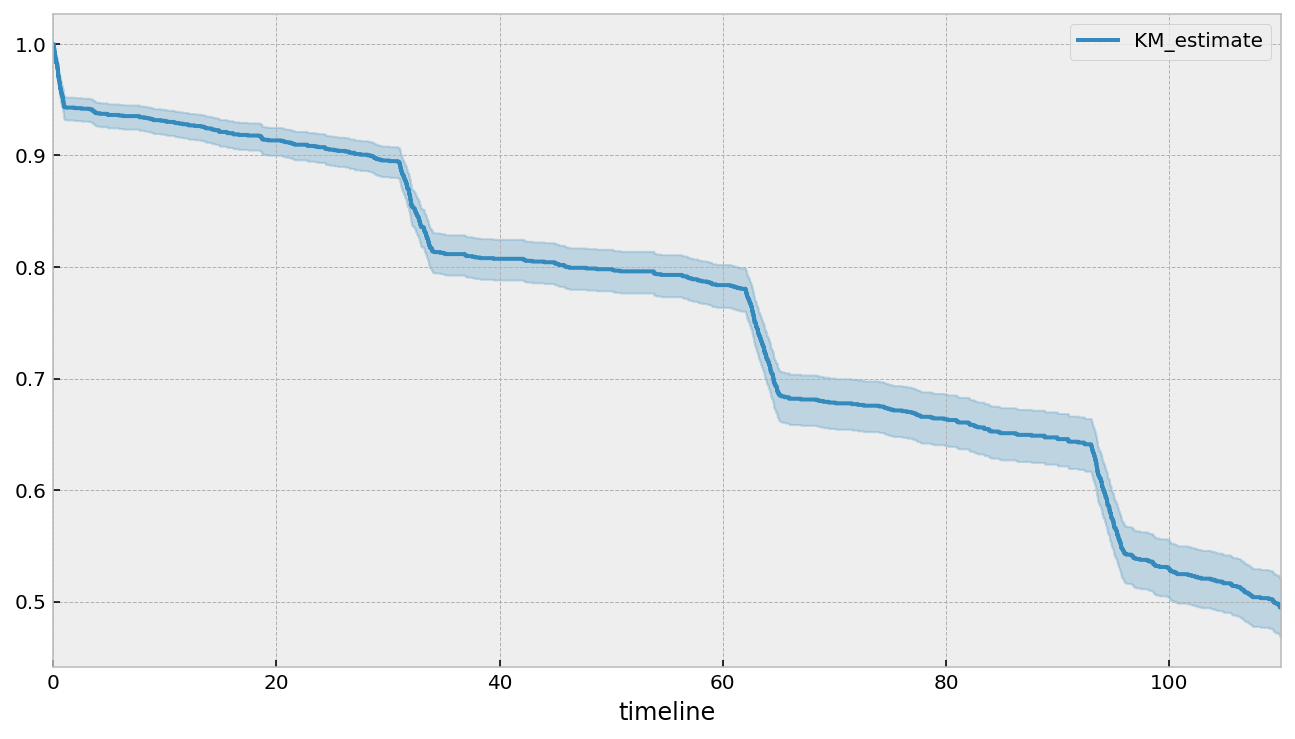

In [22]:
kmf = KaplanMeierFitter().fit(df['T'], df['E'])
kmf.plot(figsize=(11,6));

To borrow a term from finance, we clearly have different _regimes_ that a customer goes through: periods of low churn and periods of high churn, both of which are predictable. This predictability and "sharp" changes in hazards suggests that a piecewise hazard model may work well: hazard is constant during intervals, but varies over different intervals. 

Furthermore, we can imagine that inidivdual customer variables influence their likelihood to churn as well. Since we have baseline information, we can fit a regression model. For simplicity, let's assume that a customer's hazard is constant in each period, however it varies over each customer (heterogenity in customers). 

Our hazard model looks like¹:
$$
 h(t\;|\;x) = \begin{cases}
                        \lambda_0(x)^{-1},  & t \le \tau_0 \\
                        \lambda_1(x)^{-1} & \tau_0 < t \le \tau_1 \\
                        \lambda_2(x)^{-1} &  \tau_1 < t \le \tau_2 \\
                        ...
                      \end{cases}
$$

and $\lambda_i(x) = \exp(\mathbf{\beta}_i x^T), \;\; \mathbf{\beta}_i = (\beta_{i,1}, \beta_{i,2}, ...)$. That is, each period has a hazard rate, $\lambda_i$ the is the exponential of a linear model. The parameters of each linear model are unique to that period - different periods have different parameters (later we will generalize this).  

Why do I want a model like this? Well, it offers lots of flexibilty (at the cost of efficiency though), but importantly I can see:

1. Influence of variables over time.
2. Looking at important variables at specific "drops" (or regime changes). For example, what variables cause the large drop at the start? What variables prevent death at the second billing?
3. Predictive power: since we model the hazard more accurately (we hope) than a simpler parametric form, we have better estimates of a subjects survival curve. 

¹ I specifiy the reciprocal because that follows lifelines convention for exponential and Weibull hazards. In practice, it means the interpretation of the sign is possibly different. 

In [23]:
pew = PiecewiseExponentialRegressionFitter(
    breakpoints=breakpoints)\
    .fit(df, "T", "E")

Above we fit the regression model. We supplied a list of breakpoints that we inferred from the survival function and from our domain knowledge. 

Let's first look at the average hazard in each interval, over time. We should see that during periods of high customer churn, we also have a high hazard. We should also see that the hazard is constant in each interval. 

Text(0, 0.5, 'Hazard')

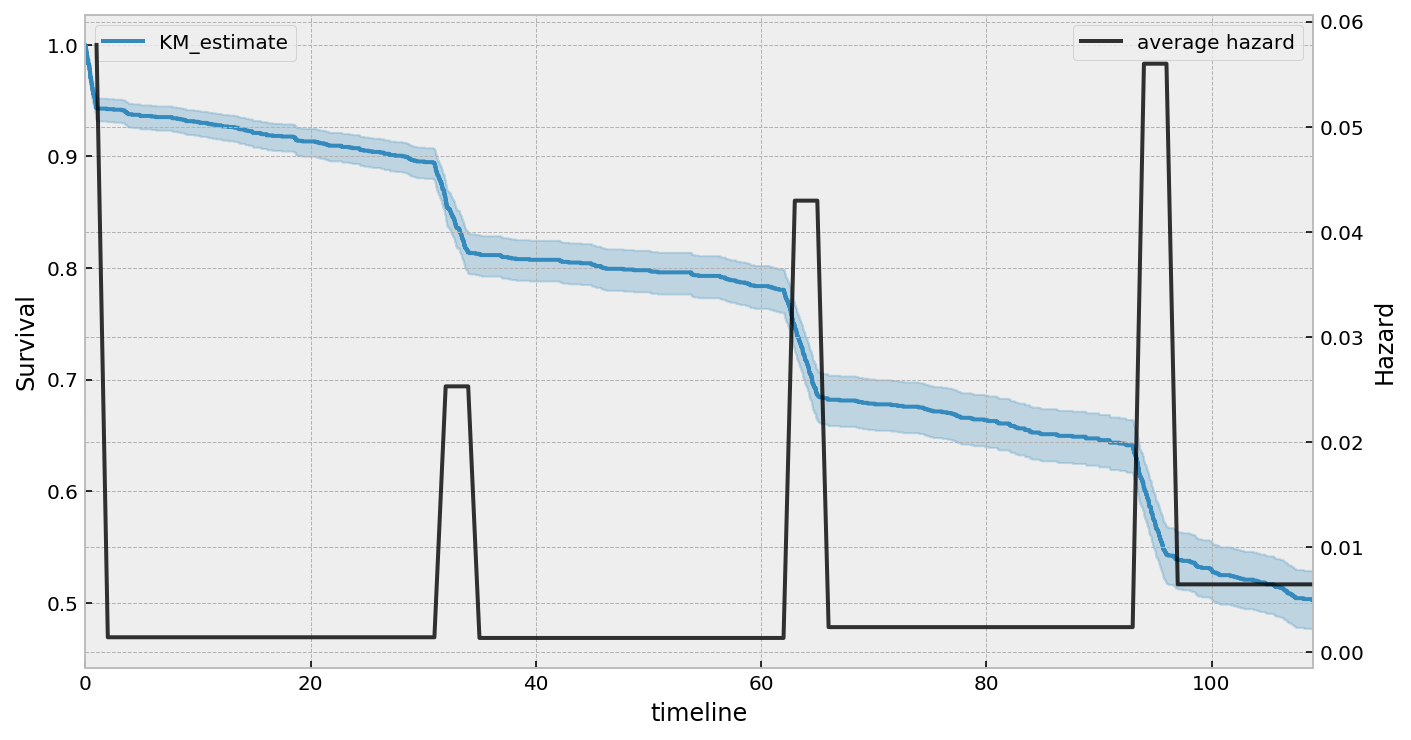

In [24]:
fig, ax = plt.subplots(1,1)
kmf.plot(figsize=(11,6), ax=ax);
ax.legend(loc="upper left")
ax.set_ylabel("Survival")

ax2 = ax.twinx()

pew.predict_cumulative_hazard(
        pew._norm_mean.to_frame(name='average hazard').T,
        times=np.arange(0, 110),
    ).diff().plot(ax=ax2, c='k', alpha=0.80)
ax2.legend(loc="upper right")
ax2.set_ylabel("Hazard")

It's obvious that the highest average churn is in the first few days, and then high again in the latter billing periods. 

So far, we have only been looking at the aggregated population - that is, we haven't looked at what variables are associated with churning. Let's first start with investigating what is causing (or associated with) the drop at the second billing event (~day 30). 

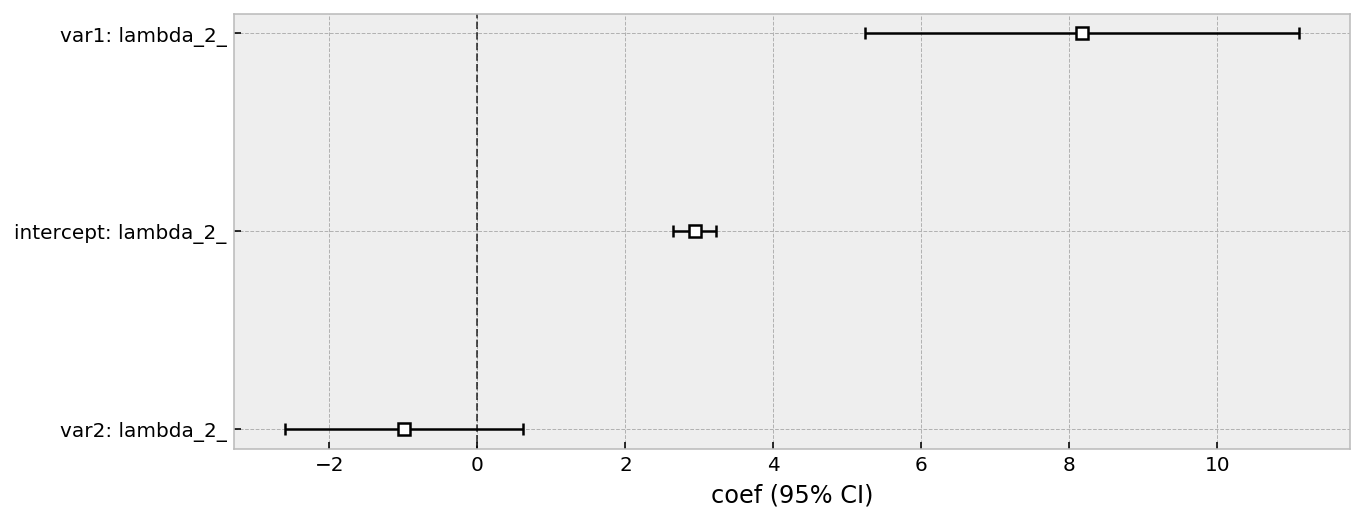

In [25]:
fig, ax = plt.subplots(figsize=(10, 4))
pew.plot(parameter=['lambda_2_'], ax=ax);

From this forest plot, we can see that the `var1` has a _protective_ effect, that is, customers with a high `var1` are much less likely to churn in the second billing periods. `var2` has little effect, but possibly negative. From a business point of view, maximizing `var1` for customers would be a good move (assuming it's a causal relationship).  

We can look at all the coefficients in one large forest plot, see below. We see a distinct alternating pattern in the `_intercepts` variable. This makes sense, as our hazard rate shifts between high and low churn regimes. The influence of `var1` seems to spike in the 3rd regime (`lambda_2_`), and then decays back to zero. The influence of `var2` looks like it starts to become more negative over time, that is, is associated with more churn over time. 

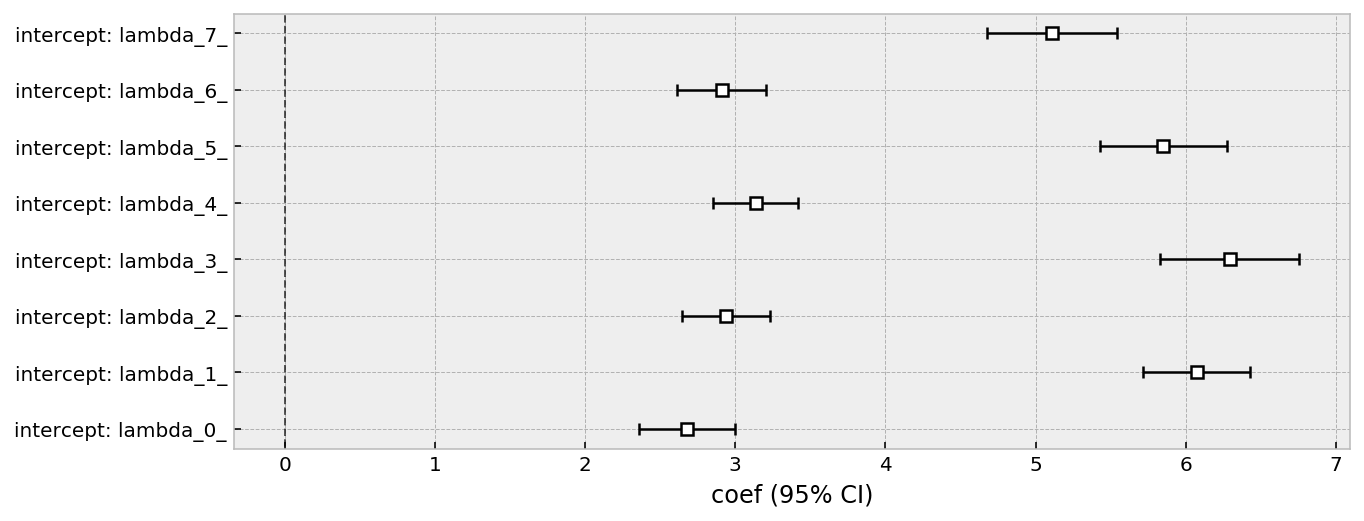

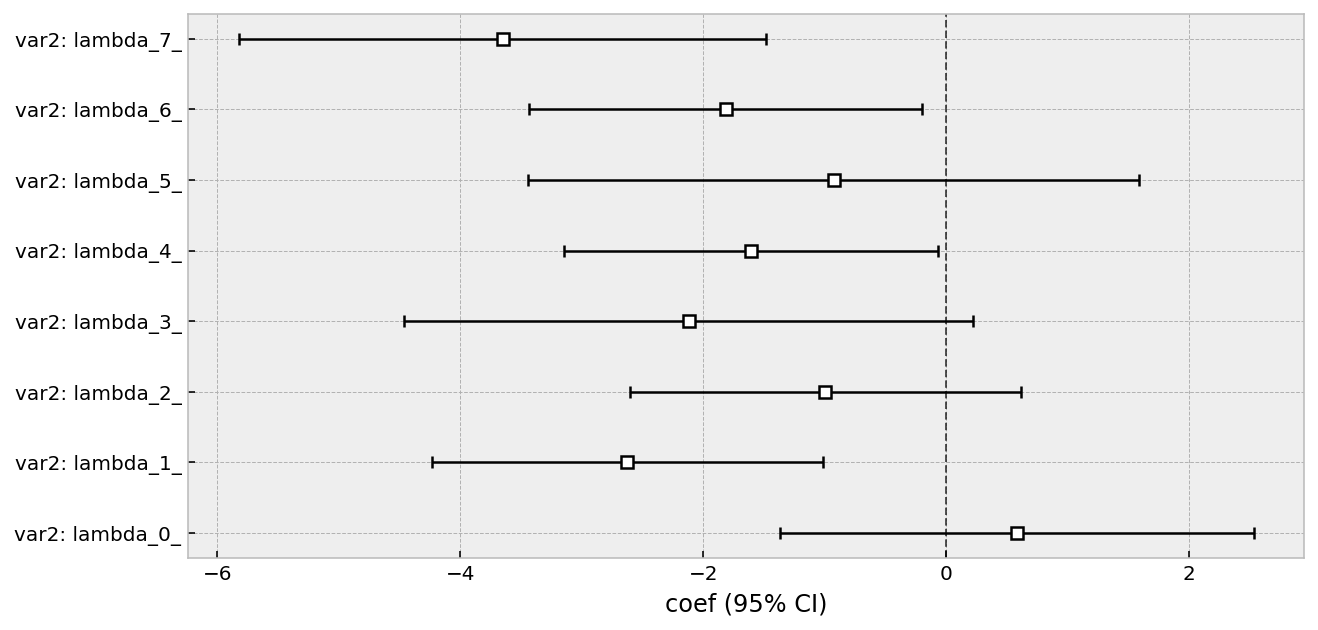

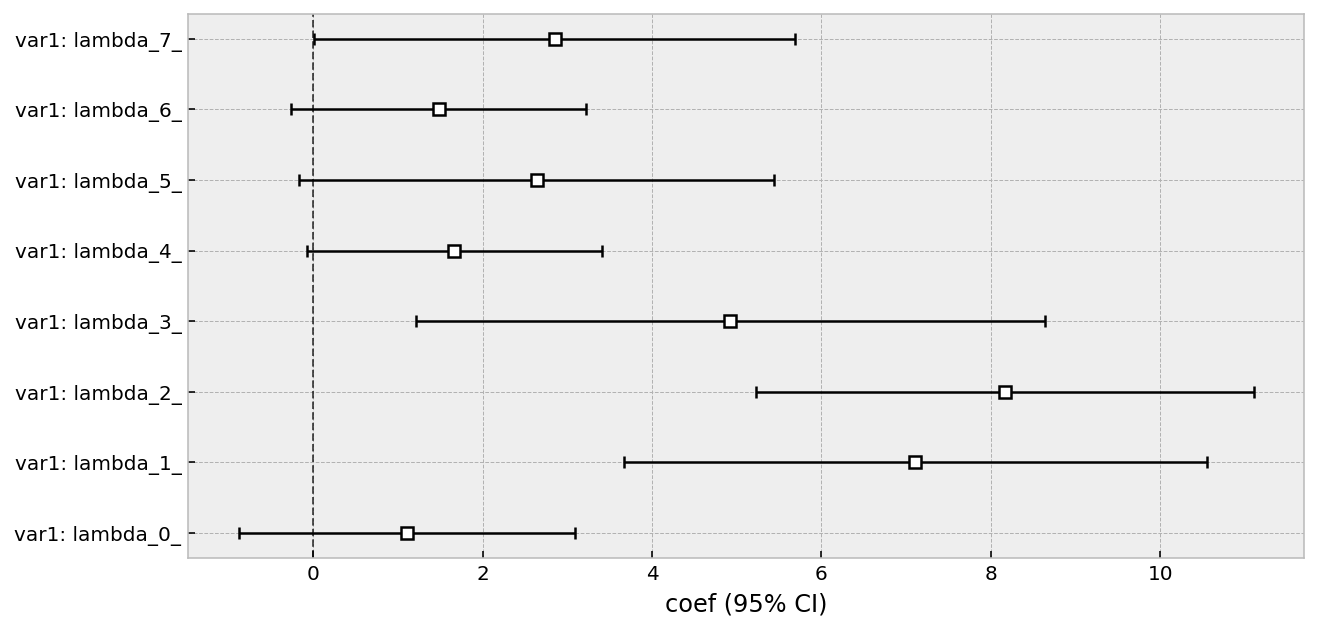

In [31]:
fig, ax = plt.subplots(figsize=(10, 4))
pew.plot(columns=['intercept'], ax=ax);

fig, ax = plt.subplots(figsize=(10, 5))
pew.plot(columns=['var2'], ax=ax);

fig, ax = plt.subplots(figsize=(10, 5))
pew.plot(columns=['var1'], ax=ax);

If we suspect there is some parameter sharing between intervals, or we want to regularize (and hence share information) between intervals, we can include a penalizer which penalizes the variance of the estimates per covariate.

Note: we do _not_ penalize the intercept, currently. This is a modellers decision, but I think it's better not too.

Specifically, our penalized log-likelihood, $PLL$, looks like:

$$
PLL = LL - \alpha \sum_j \hat{\sigma}_j^2
$$

where $\hat{\sigma}_j$ is the standard deviation of $\beta_{i, j}$ over all periods $i$. This acts as a regularizer and much like a multilevel component in Bayesian statistics. In the above inference, we implicitly set $\alpha$ equal to 0. Below we examine some more cases of varying $\alpha$. First we set $\alpha$ to an extremely large value, which should push the variances of the estimates to zero. 


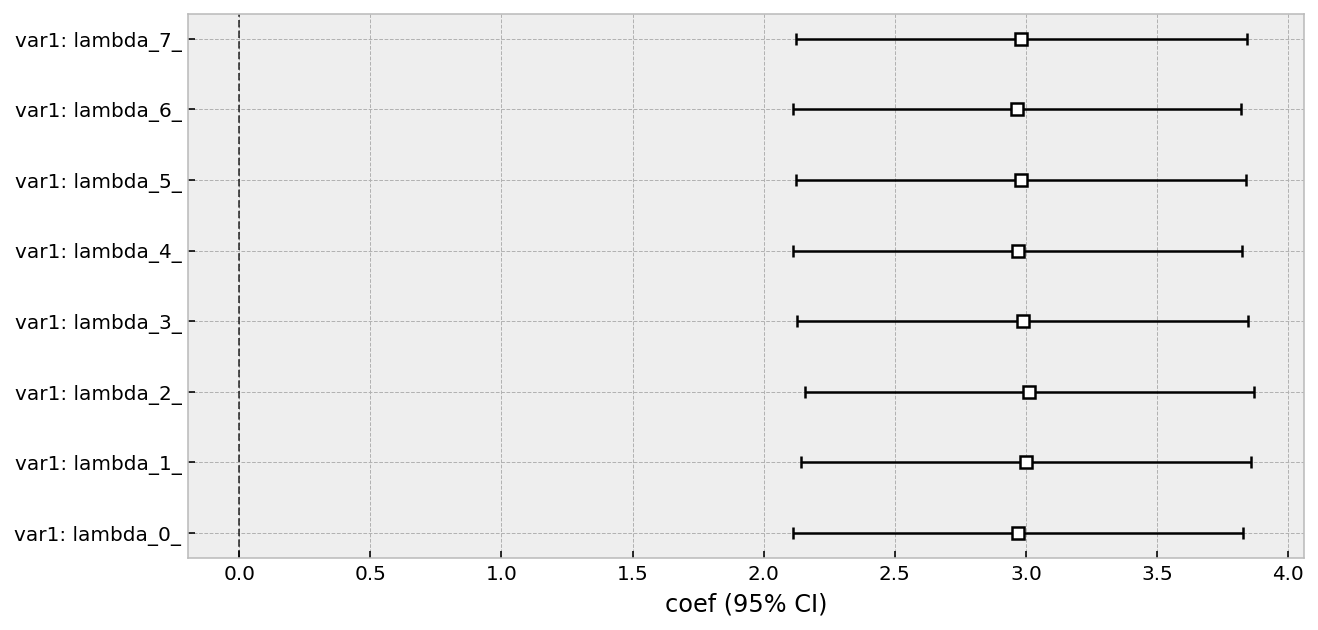

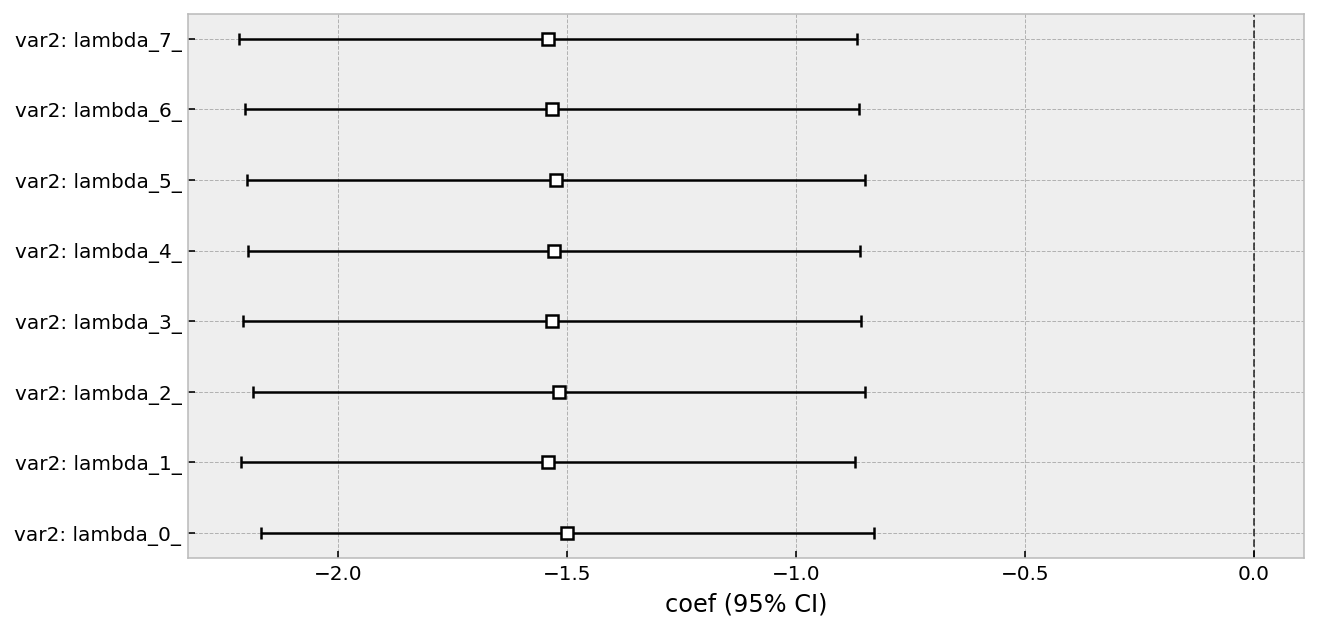

In [32]:
# Extreme case, note that all the covariates' parameters are almost identical. 
pew = PiecewiseExponentialRegressionFitter(
    breakpoints=breakpoints, 
    penalizer=20.0)\
    .fit(df, "T", "E")

fig, ax = plt.subplots(figsize=(10, 5))
pew.plot(columns=['var1'], ax=ax);
fig, ax = plt.subplots(figsize=(10, 5))
pew.plot(columns=['var2'], ax=ax);

As we suspected, a very high penalizer will constrain the same parameter between intervals to be equal (and hence 0 variance). This is the same as the model: 

$$
 h(t\;|\;x) = \begin{cases}
                        \lambda_0(x)^{-1},  & t \le \tau_0 \\
                        \lambda_1(x)^{-1} & \tau_0 < t \le \tau_1 \\
                        \lambda_2(x)^{-1} &  \tau_1 < t \le \tau_2 \\
                        ...
                      \end{cases}
$$

and $\lambda_i(x) = \exp(\mathbf{\beta} x^T), \;\; \mathbf{\beta} = (\beta_{1}, \beta_{2}, ...)$. Note the resuse of the $\beta$s between intervals. 

This model is the same model proposed in ["Piecewise Exponential Models for Survival Data with Covariates"](https://projecteuclid.org/euclid.aos/1176345693). 

One nice property of this model is that because of the extreme information sharing between intervals, we have maximum information for inferences, and hence small standard errors per parameter. However, if the parameters effect is truely time-varying (and not constant), then the standard error will be inflated and a less constrained model is better.   

Below we examine a inbetween penalty, and compare it to the zero penalty. 

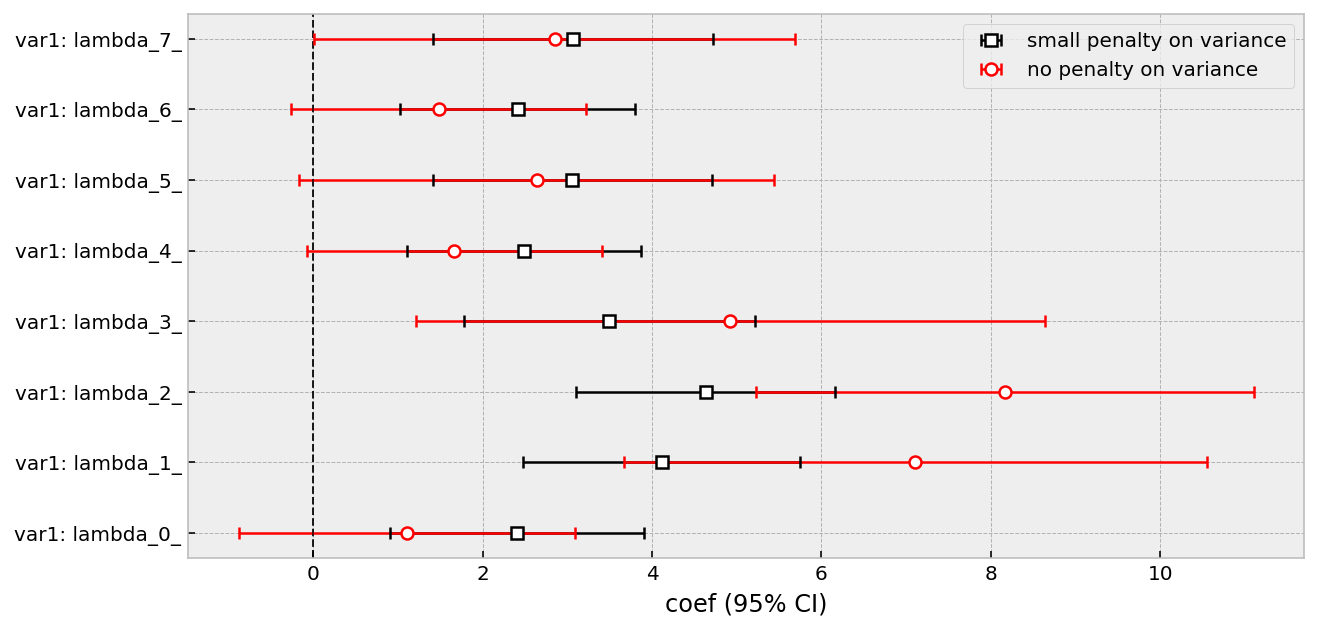

In [39]:
# less extreme case
pew = PiecewiseExponentialRegressionFitter(
    breakpoints=breakpoints, 
    penalizer=.25)\
    .fit(df, "T", "E")

fig, ax = plt.subplots(figsize=(10, 5))
pew.plot(columns=['var1'], ax=ax, fmt="s", label="small penalty on variance")

# compare this to the no penalizer case
pew_no_penalty = PiecewiseExponentialRegressionFitter(
    breakpoints=breakpoints, 
    penalizer=0)\
    .fit(df, "T", "E")

pew_no_penalty.plot(columns=['var1'], ax=ax, c="r", fmt="o", label="no penalty on variance")
plt.legend();

We can see that: 

1) on average, the standard errors are smaller in the penalty case
2) parameters are pushed closer together (the will converge to their average if we keep increasing the penalty)
3) the intercepts are barely effected. 

I think, in practice, adding a small penalty is the right thing to do. It's extremely unlikely that intervals are independent, and extremely unlikely that parameters are constant over intervals. 


Like all _lifelines_ models, we have prediction methods too. This is where we can see customer heterogenity vividly. 

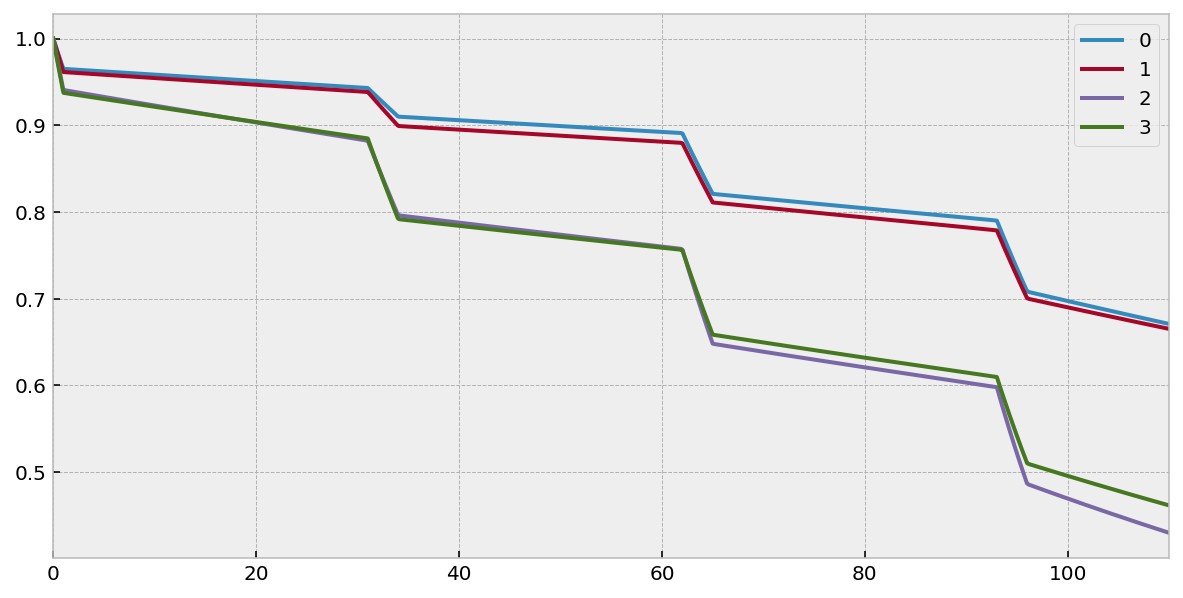

In [35]:
# Some prediction methods
pew.predict_survival_function(df.loc[0:3]).plot(figsize=(10, 5));

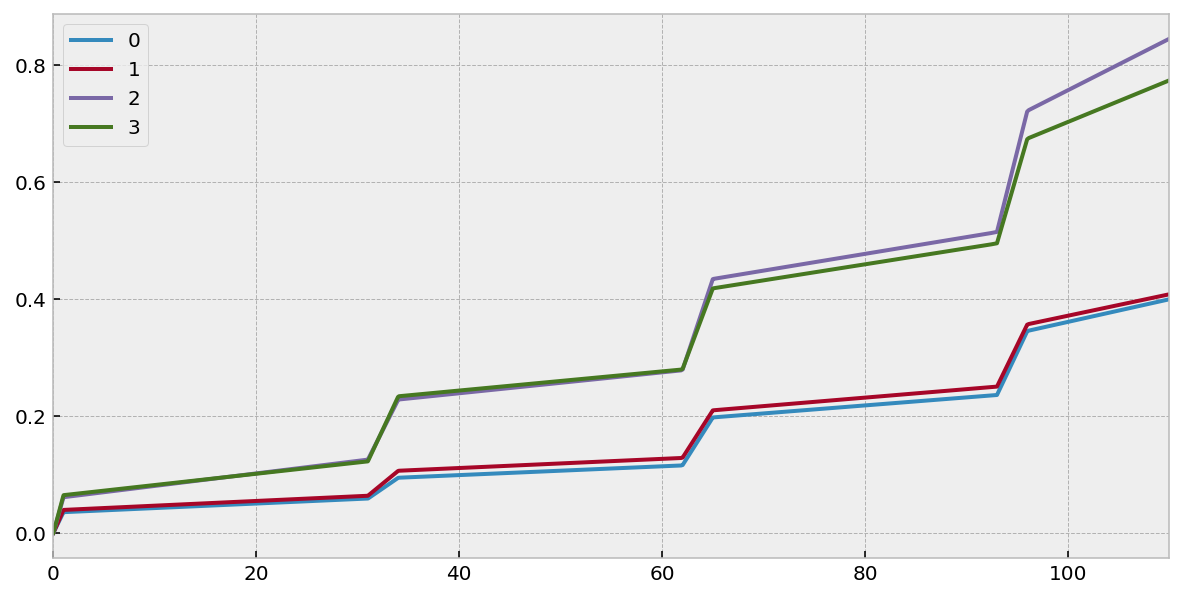

In [36]:
pew.predict_cumulative_hazard(df.loc[0:3]).plot(figsize=(10, 5));

In [37]:
pew.predict_median(df.loc[0:5])

,0.5
0,inf
1,inf
2,95.615613
3,98.772531
4,96.694185
5,inf
